Need to have torch installed (so I switched from my tensorflow to torch conda env)

In [1]:
# Check if we have data.zip:
import os
if not os.path.exists('data.zip'):
    # Download the data:
    !wget https://download.pytorch.org/tutorial/data.zip
if not os.path.exists('data'):
    # Unzip the data:
    !unzip data.zip

import sys
sys.path.append("../../Code/Lecture6-NamesRNN/")

from rnn_utils import *

['data/names/Spanish.txt', 'data/names/French.txt', 'data/names/Dutch.txt', 'data/names/Scottish.txt', 'data/names/Czech.txt', 'data/names/Arabic.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Vietnamese.txt', 'data/names/Japanese.txt', 'data/names/Polish.txt', 'data/names/Chinese.txt', 'data/names/Russian.txt', 'data/names/English.txt', 'data/names/Italian.txt', 'data/names/Irish.txt', 'data/names/Korean.txt', 'data/names/Portuguese.txt']
Slusarski


In [2]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
# Take validation and test sets:
def train_test_split(data, test_size=0.2, random_state=None):
    if random_state is not None:
        import random
        random.seed(random_state)
    data = list(data)
    random.shuffle(data)
    split = int(len(data) * (1 - test_size))
    return data[:split], data[split:]


category_lines_train = {}
category_lines_val = {}
category_lines_test = {}
for category in all_categories:
    lines = category_lines[category]
    lines_train, lines_test = train_test_split(lines, test_size=0.05, random_state=42)
    lines_train, lines_val = train_test_split(lines_train, test_size=0.1, random_state=42)
    category_lines_train[category] = lines_train
    category_lines_val[category] = lines_val
    category_lines_test[category] = lines_test

['data/names/Spanish.txt', 'data/names/French.txt', 'data/names/Dutch.txt', 'data/names/Scottish.txt', 'data/names/Czech.txt', 'data/names/Arabic.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Vietnamese.txt', 'data/names/Japanese.txt', 'data/names/Polish.txt', 'data/names/Chinese.txt', 'data/names/Russian.txt', 'data/names/English.txt', 'data/names/Italian.txt', 'data/names/Irish.txt', 'data/names/Korean.txt', 'data/names/Portuguese.txt']
Slusarski


In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [4]:
import torch.nn as nn
DEVICE='cpu'
class LinearRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LinearRNN, self).__init__()

        self.hidden_size = hidden_size
        # Combine input and hidden states (concatenation)
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # Send hidden states to output
        self.h2o = nn.Linear(hidden_size, output_size)
        # Output will be in logits
        self.softmax = nn.LogSoftmax(dim=1)

        # Put all layers into the device
        self.to(DEVICE)

    def forward(self, input, hidden):
        input = input.to(DEVICE)
        hidden = hidden.to(DEVICE)
        # First combine the input and hidden state on the first axis
        combined = torch.cat((input, hidden), 1)
        # Then send it to the hidden layer (linear layer)
        hidden = self.i2h(combined)

        # Then send it to the output layer (linear layer) as logit
        output = self.h2o(hidden)
        output = self.softmax(output)

        # We'll want both the output (logit for each class) 
        # and the hidden state for the next step
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size, device='cuda')

n_hidden = 128
rnn = LinearRNN(n_letters, n_hidden, n_categories)

In [5]:
input = letterToTensor('A').to('cuda')
hidden = torch.zeros(1, n_hidden).to('cuda')

output, next_hidden = rnn(input, hidden)

In [6]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9097, -2.9970, -2.9298, -2.8949, -2.9696, -2.8444, -2.8200, -2.8845,
         -2.9490, -2.9201, -2.8596, -2.9086, -2.9162, -2.8213, -2.8018, -2.8295,
         -2.9696, -2.8306]], grad_fn=<LogSoftmaxBackward0>)


In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Italian', 14)


In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines_train[category])
    category_tensor = torch.tensor([all_categories.index(category)], 
                                   dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '==> name =', line)

category = Scottish ==> name = Hughes
category = Vietnamese ==> name = Luc
category = Chinese ==> name = Zhong
category = Chinese ==> name = Yau
category = German ==> name = Lieberenz
category = Dutch ==> name = Romijn
category = Arabic ==> name = Tuma
category = Greek ==> name = Houlis
category = Italian ==> name = Guidi
category = Vietnamese ==> name = Tron


In [9]:
# Get the total length of each list in the dictionary
def get_total_length(d):
    return sum(len(v) for v in d.values())
val_length = get_total_length(category_lines_val)

In [10]:
losses, val_losses, test_loss = train_loop(rnn, 0.001, 5e5, device=DEVICE)

5000 1% (0m 4s) 2.9547 Sook / Irish ✗ (Korean)
10000 2% (0m 9s) 2.9624 Ko / Portuguese ✗ (Korean)
15000 3% (0m 14s) 2.8198 Hanania / Czech ✗ (Arabic)
20000 4% (0m 19s) 2.5407 Nardi / Italian ✓
25000 5% (0m 24s) 2.8026 Copland / Italian ✗ (English)
30000 6% (0m 28s) 3.7032 Haimi / Japanese ✗ (Russian)
35000 7% (0m 33s) 2.6691 Rios / Arabic ✗ (Portuguese)
40000 8% (0m 38s) 1.7291 Pinho / Portuguese ✓
45000 9% (0m 42s) 1.9609 Quyen / Korean ✗ (Vietnamese)
50000 10% (0m 47s) 0.8078 Yan / Chinese ✓
55000 11% (0m 52s) 1.3293 Sitko / Polish ✓
60000 12% (0m 57s) 0.3689 Takudo / Japanese ✓
65000 13% (1m 1s) 0.0403 Chrysanthopoulos / Greek ✓
70000 14% (1m 6s) 1.2483 Vuu / Chinese ✗ (Vietnamese)
75000 15% (1m 11s) 0.9818 Ankeren / Dutch ✓
80000 16% (1m 15s) 5.8880 Lis / Korean ✗ (Polish)
85000 17% (1m 20s) 1.3287 Simoes / Portuguese ✓
90000 18% (1m 25s) 1.6592 Cabral / Portuguese ✓
95000 19% (1m 30s) 1.4508 Silveira / Spanish ✗ (Portuguese)
100000 20% (1m 35s) 0.8141 Kosmatka / Polish ✓
105000 21

(0.0, 3.0)

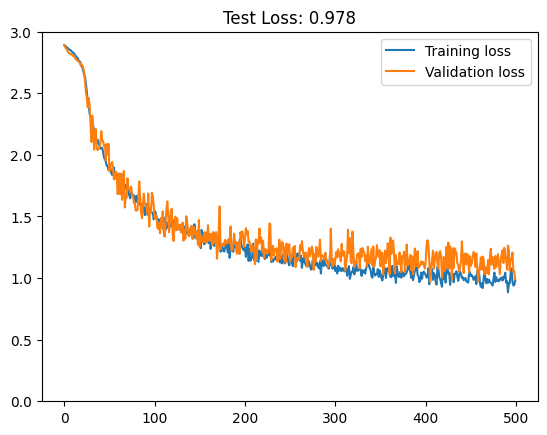

In [11]:
plt.figure()
plt.plot(losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title('Test Loss: {:.3f}'.format(test_loss))
plt.ylim(0, 3)

/tmp/ipykernel_307563/326828356.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_307563/326828356.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


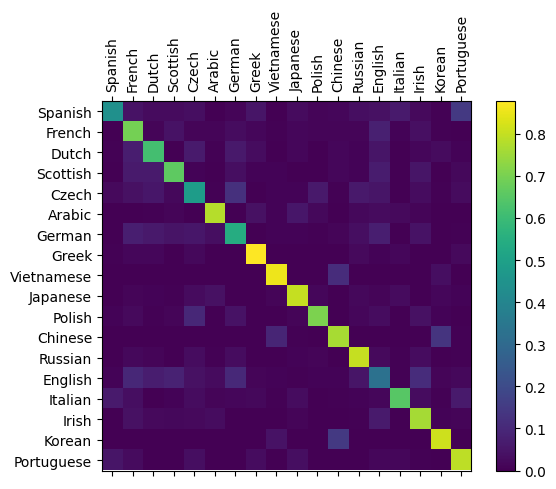

In [12]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(rnn, line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(rnn, line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [13]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(rnn,lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Kulkarni') # Indian
predict('Haehn')
predict('Adamczyk') # Polish
predict('Piemontese') # Italian
predict('Makarenko') # Ukrainian
predict('dalbayob')


> Kulkarni
(-0.63) Czech
(-1.85) Polish
(-2.06) Russian

> Haehn
(-1.20) German
(-1.25) Irish
(-2.04) Dutch

> Adamczyk
(-0.06) Polish
(-3.53) Russian
(-3.86) Czech

> Piemontese
(-0.20) Dutch
(-2.46) Greek
(-3.08) French

> Makarenko
(-0.04) Russian
(-3.94) Czech
(-4.10) Japanese

> dalbayob
(-0.42) Russian
(-1.95) Arabic
(-2.51) English
